# Mini Projet : Deep Learning

### Objectif: Explorer, visualiser et classifier le jeu de données Fashion-MNIST.

##### Librairie

In [1]:
import keras
import numpy as np 
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import os
import seaborn as sns
from time import time
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics.pairwise import manhattan_distances
from collections import Counter
import scikitplot as skplt
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization,Flatten,Reshape, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.datasets import fashion_mnist
from keras import backend as K
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical 
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.cluster import KMeans
from tqdm import tqdm_notebook
from MulticoreTSNE import MulticoreTSNE as TSNE
import multiprocessing as mp
from skimage.measure import compare_psnr,compare_mse
from IPython.display import Image

Using TensorFlow backend.


On teste si le GPU est disponible

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

On charge le jeux de données Fashion MNIST à partir de Keras.
On change la forme des jeux de données suivant les méthodes que nous allons utiliser plus tard.

In [3]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [5]:
X_train_2d = X_train.reshape(X_train.shape[0], 784)
X_test_2d = X_test.reshape(X_test.shape[0], 784)
X_train_2d = X_train_2d.astype("float32")/255.
X_test_2d = X_test_2d.astype("float32")/255.
print('X_train shape 2d :', X_train_2d.shape)
print(X_train_2d.shape[0], 'train samples')
print(X_test_2d.shape[0], 'test samples')

X_train shape 2d : (60000, 784)
60000 train samples
10000 test samples


In [6]:
X_train_reshape = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_reshape = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train_reshape = X_train_reshape.astype("float32")/255.
X_test_reshape = X_test_reshape.astype("float32")/255.
print('X_train shape:', X_train_reshape.shape)
print(X_train_reshape.shape[0], 'train samples')
print(X_test_reshape.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


On défini les noms de classes par ordre ainsi que leur couleurs associées pour les futures plots.

In [7]:
colors = ['black', 'blue', 'violet', 'yellow', 'white', 'red', 'lime', 'aqua', 'orange', 'gray']
labels = ['T-shirt / Haut', 'Pantalon', 'Pull', 'Robe', 'Manteau', 'Sandales', 'Chemise', 'Baskets', 'Sacs', 'Bottines']

#### Exploration

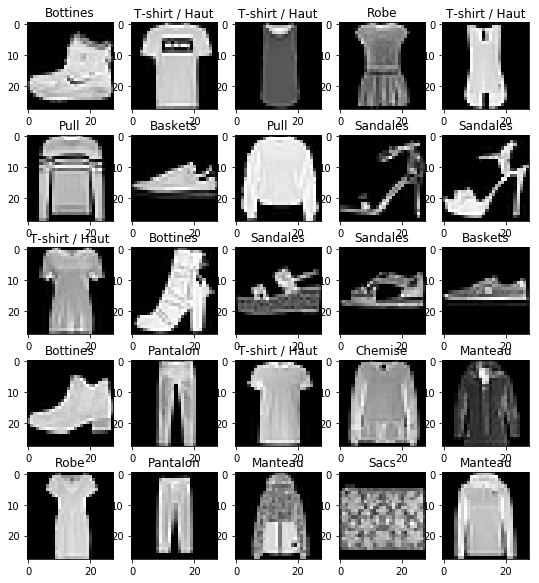

In [8]:
plt.figure(figsize=(9, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(labels[int(y_train[i])])
plt.show()

#### Fonctions 

Nous définissons dans cette sections les différentes fonctions utiles aux projets.

In [9]:
def plot_embedding(x,y,title=None):
    plt.figure(figsize=(12, 12))
    for i in range(10):
        plt.scatter(x[y == i, 0], x[y == i, 1], 
                    c=colors[i], label=labels[i], edgecolors='black')
    plt.legend()
    plt.title(title)
    plt.show()

In [10]:
def display_reconstructed(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

In [11]:
def reconstruction(X, n, trans):
    """
    Creates a reconstruction of an input record, X, using the topmost (n) vectors from the
    given transformation (trans)
    
    Note 1: In this dataset each record is the set of pixels in the image (flattened to 
    one row).
    Note 2: X should be normalized before input.
    """
    vectors = [trans.components_[n] * X[n] for n in range(0, n)]
    
    # Invert the PCA transformation.
    ret = trans.inverse_transform(X)
    
    # This process results in non-normal noise on the margins of the data.
    # We clip the results to fit in the [0, 1] interval.
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

In [12]:
def n_sample_reconstructions(X, n_samples=5, trans_n=120, trans=None):
    """
    Returns a tuple with `n_samples` reconstructions of records from the feature matrix X,
    as well as the indices sampled from X.
    """
    sample_indices = np.round(np.random.random(n_samples)*len(X))
    return (sample_indices, 
            np.vstack([reconstruction(X[int(ind)], trans_n, trans) for ind in sample_indices]))

In [13]:
def plot_reconstructions(X, n_samples=5, trans_n=120, trans=None):
    """
    Plots `n_samples` reconstructions.
    """
    fig, axarr = plt.subplots(n_samples, 3, figsize=(12, n_samples*4))
    ind, reconstructions = n_sample_reconstructions(X, n_samples, trans_n, trans)
    for (i, (ind, reconstruction)) in enumerate(zip(ind, reconstructions)):
        ax0, ax1, ax2 = axarr[i][0], axarr[i][1], axarr[i][2]
        sns.heatmap(X_full[int(ind), :].reshape(28, 28), cmap='gray_r', ax=ax0)
        sns.heatmap(reconstruction.reshape(28, 28), cmap='gray_r', ax=ax1)
        sns.heatmap(np.abs(X_full[int(ind), :] - reconstruction).reshape(28, 28), 
                    cmap='gray_r', ax=ax2)
        ax0.axis('off')
        ax0.set_aspect('equal')
        ax0.set_title("Original Image", fontsize=12)
        ax1.axis('off')
        ax1.set_aspect('equal')
        ax1.set_title(str(trans_n)+"-Vector Reconstruction", fontsize=12)
        ax2.axis('off')
        ax2.set_title("Original-Reconstruction Difference", fontsize=12)
        ax2.set_aspect('equal')

In [14]:
def acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

Vérifions la fréquence des différentes classes

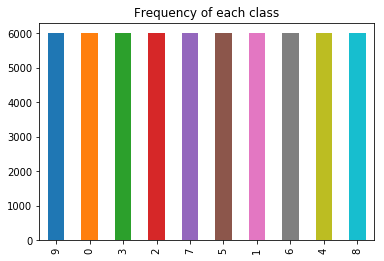

In [15]:
val_perc = Counter(list(y_train))
pd.Series(Counter(list(y_train))).plot(kind='bar',title="Frequency of each class")
plt.show()

#### ACP sur le jeux de données complet

In [16]:
X_full = np.concatenate((X_train_2d,X_test_2d),axis=0)
y_full = np.concatenate((y_train,y_test),axis=0)

In [17]:
t0 = time()
pca = PCA(svd_solver='full')
principalComponents = pca.fit_transform(X_full)
print("embedding time:", round(time()-t0, 3), "s")

embedding time: 3.097 s


Nuage des points sur les deux principales composantes

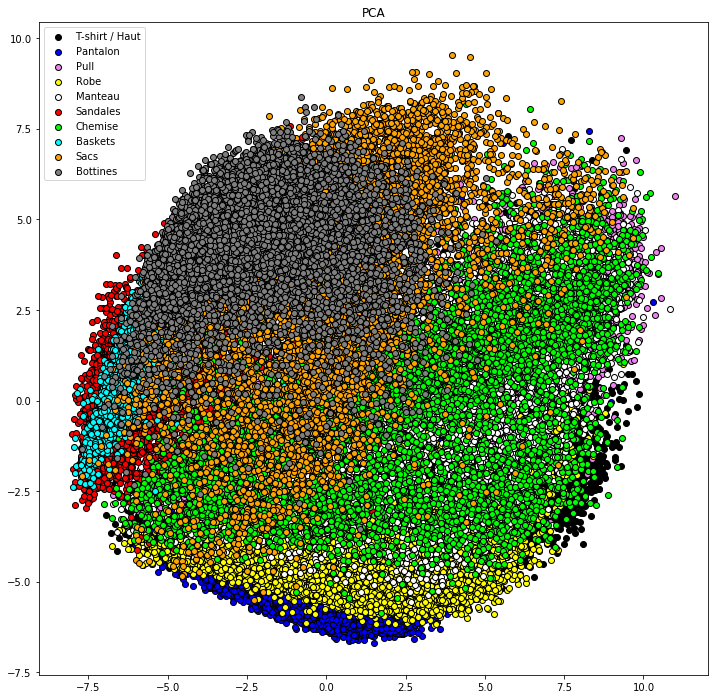

In [18]:
plot_embedding(principalComponents,y_full, "PCA")

Pourcentage d'information sur les 14 premières composantes : 75%

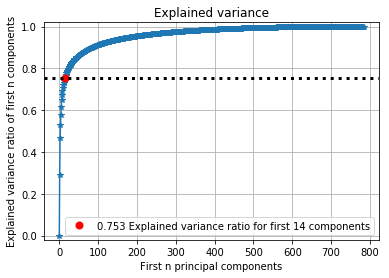

In [19]:
skplt.decomposition.plot_pca_component_variance(pca,title="Explained variance",target_explained_variance=0.75)
plt.show()

Pourcentage d'information sur les 188 premières composantes : 95%

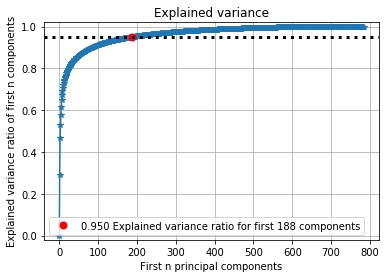

In [20]:
skplt.decomposition.plot_pca_component_variance(pca,title="Explained variance",target_explained_variance=0.95)
plt.show()

Pourcentage d'information sur les 188 premières composantes : 99%

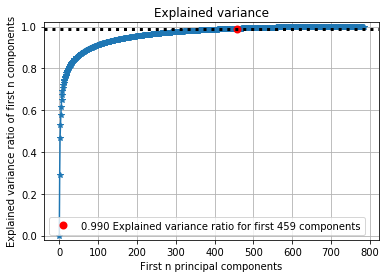

In [21]:
skplt.decomposition.plot_pca_component_variance(pca,title="Explained variance",target_explained_variance=0.99)
plt.show()

Nous allons afficher le résultats des vecteurs construit sur les 14 premières composantes

In [22]:
pca = PCA(n_components=14)
X_reduced = pca.fit(X_full).transform(X_full)

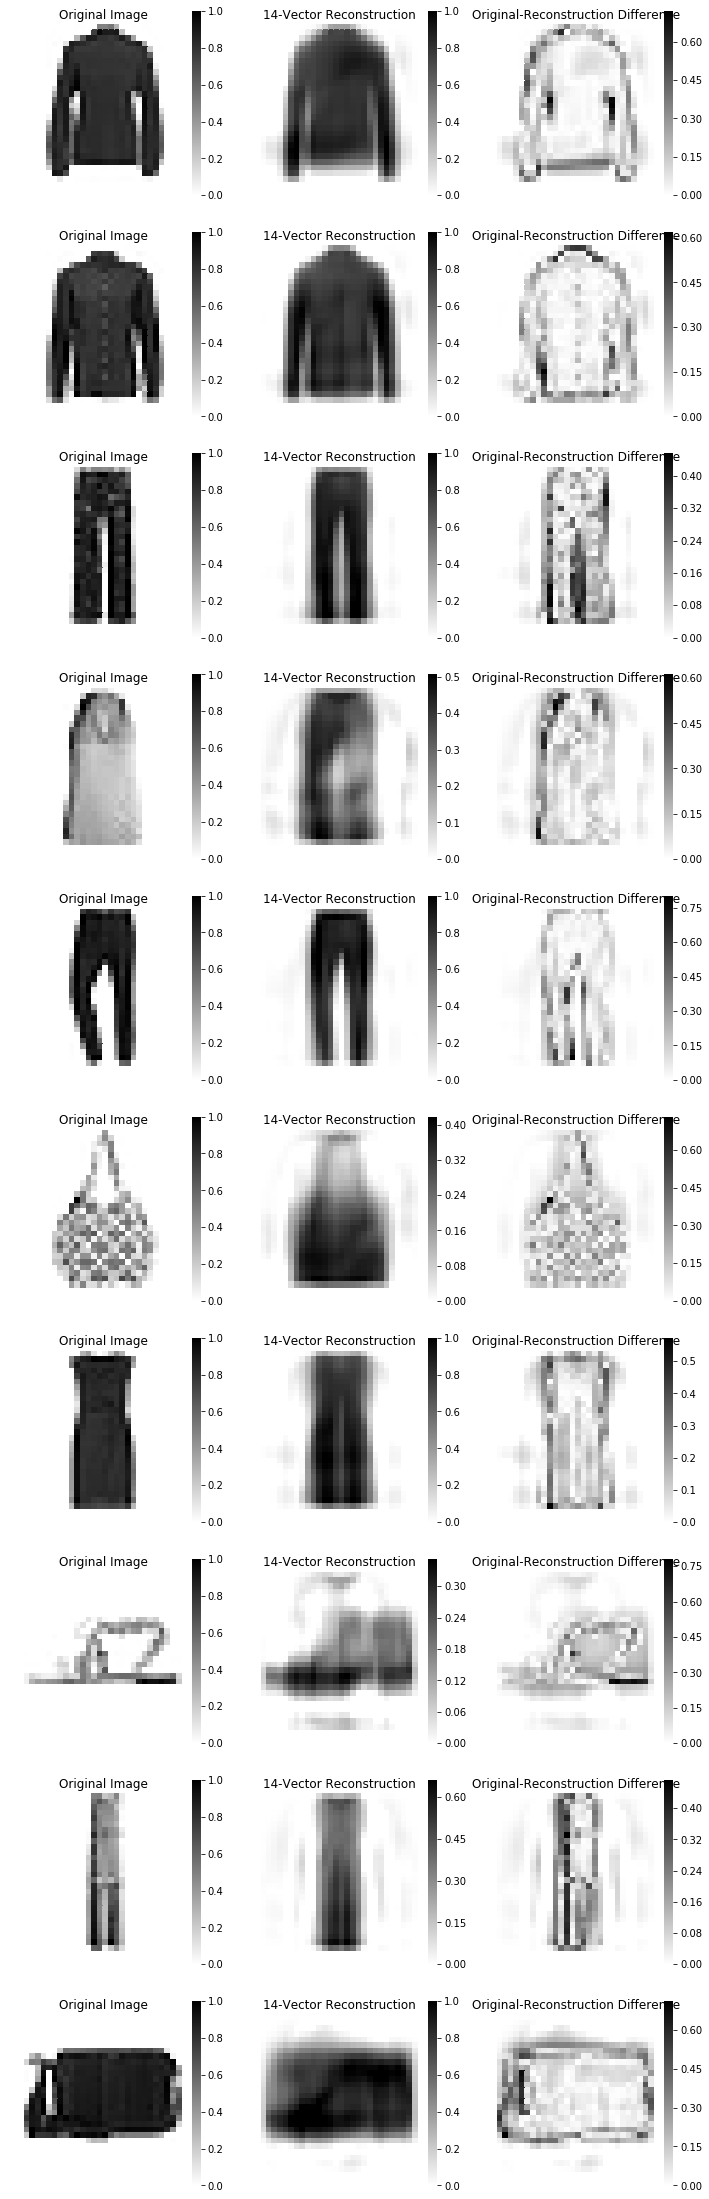

In [23]:
plot_reconstructions(X_reduced, n_samples=10, trans_n=14, trans=pca)

In [24]:
ret = pca.inverse_transform(X_reduced)

En moyenne le PSNR est de 17 et le MSE de 0.02

In [25]:
m = []
n = []
for i in range(len(X_full)):
    m.append(compare_psnr(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
    n.append(compare_mse(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
print("PSNR",scipy.stats.describe(m))    
print("MSE",scipy.stats.describe(n))    

PSNR DescribeResult(nobs=70000, minmax=(9.453348496119622, 26.723029571518005), mean=17.15801552486433, variance=4.118135699490776, skewness=-0.021275061444272048, kurtosis=0.20597837127366203)
MSE DescribeResult(nobs=70000, minmax=(0.002126655006593418, 0.11341360372245131), mean=0.02147297346882713, variance=0.00011491351244669454, skewness=1.6006894689137419, kurtosis=3.9986785357318233)


In [26]:
pca = PCA(n_components=188)
X_reduced = pca.fit(X_full).transform(X_full)

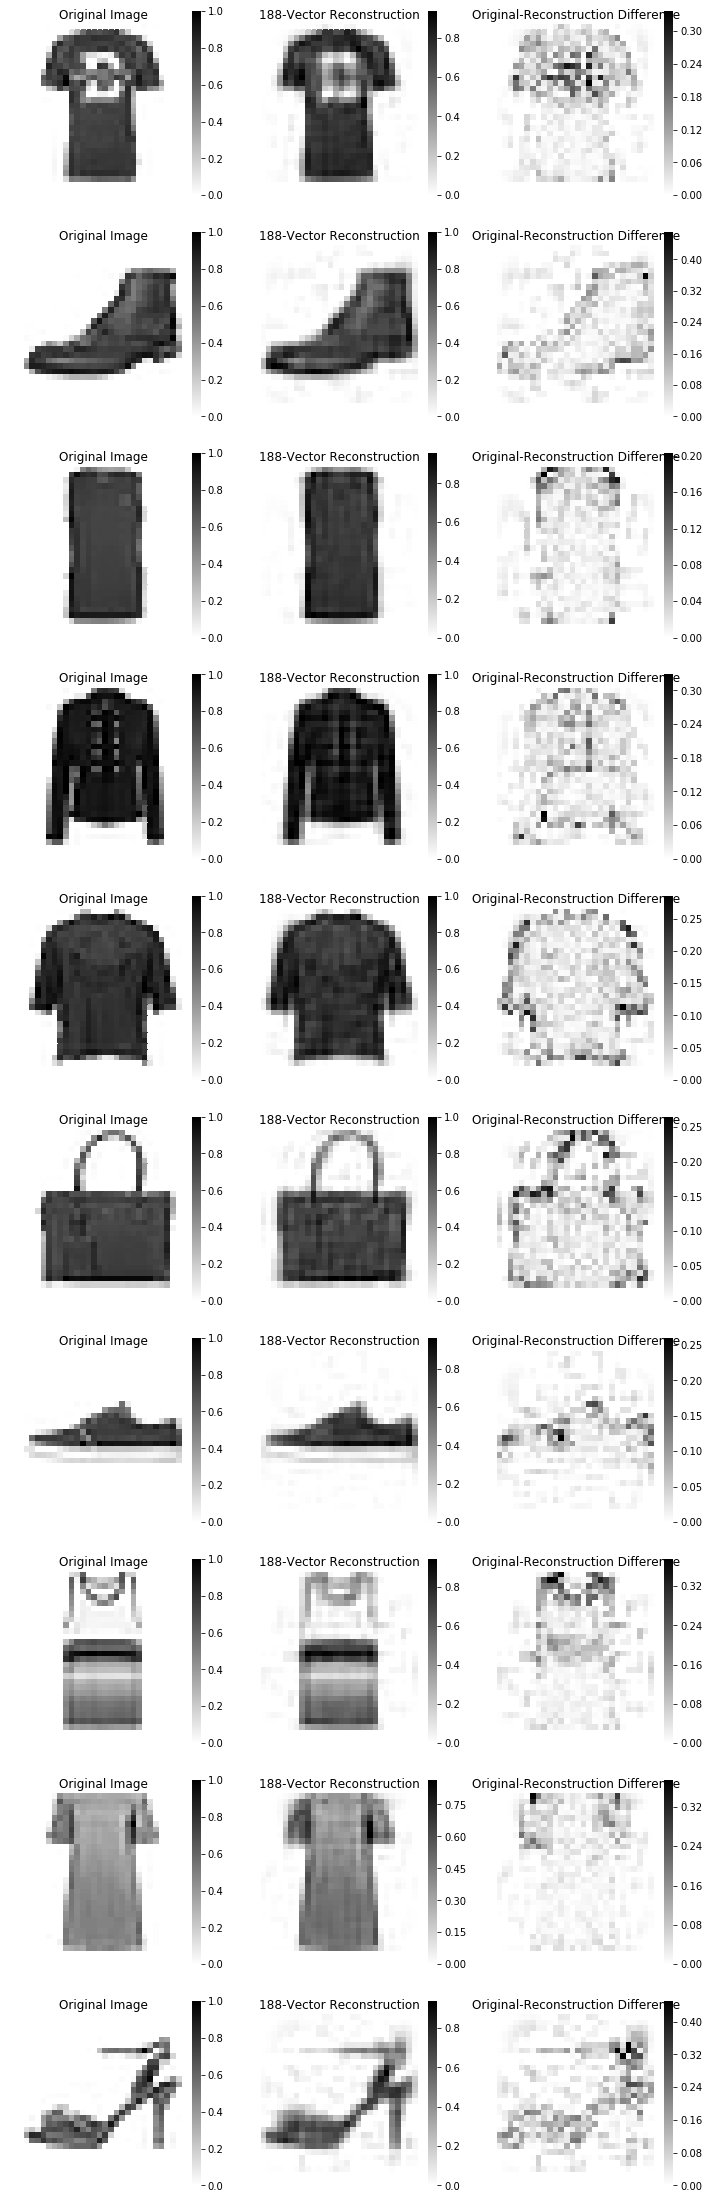

In [27]:
plot_reconstructions(X_reduced, n_samples=10, trans_n=188, trans=pca)

In [28]:
ret = pca.inverse_transform(X_reduced)

En moyenne le PSNR est de 24 et le MSE de 0.004

In [29]:
m = []
n = []
for i in range(len(X_full)):
    m.append(compare_psnr(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
    n.append(compare_mse(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
print("PSNR",scipy.stats.describe(m))    
print("MSE",scipy.stats.describe(n))   

PSNR DescribeResult(nobs=70000, minmax=(13.02445796181533, 35.15943946354105), mean=24.624642369740993, variance=8.821166222412675, skewness=-0.08362745756551558, kurtosis=-0.2943895405669781)
MSE DescribeResult(nobs=70000, minmax=(0.0003048288401608664, 0.04983726534339009), mean=0.004363474661728131, variance=1.1093309735484096e-05, skewness=2.3848387365706536, kurtosis=10.45542503903695)


In [30]:
pca = PCA(n_components=459)
X_reduced = pca.fit(X_full).transform(X_full)

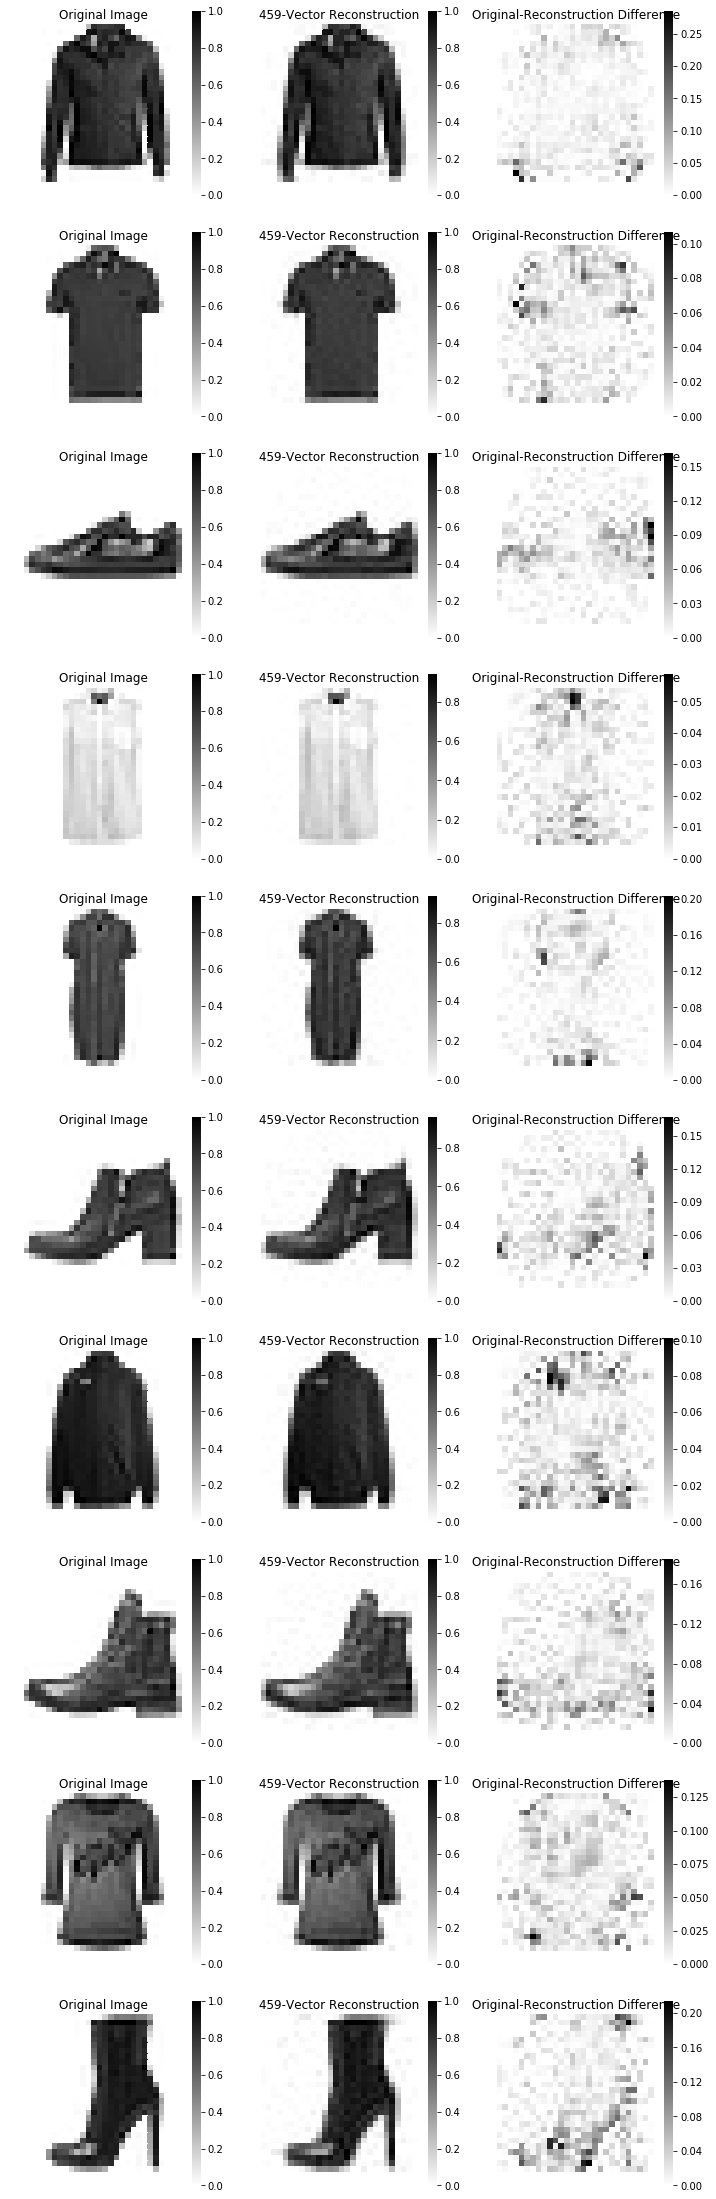

In [31]:
plot_reconstructions(X_reduced, n_samples=10, trans_n=459, trans=pca)

In [32]:
ret = pca.inverse_transform(X_reduced)

En moyenne le PSNR est de 32 et le MSE de 0.0008

In [33]:
m = []
n = []
for i in range(len(X_full)):
    m.append(compare_psnr(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
    n.append(compare_mse(X_full[i].reshape(28, 28),ret[i].reshape(28, 28)))
print("PSNR",scipy.stats.describe(m))    
print("MSE",scipy.stats.describe(n))   

PSNR DescribeResult(nobs=70000, minmax=(16.90474009887469, 45.402674799928924), mean=32.17940542971876, variance=14.385715656112747, skewness=-0.021673882214538844, kurtosis=-0.19065023091239564)
MSE DescribeResult(nobs=70000, minmax=(2.882255788146103e-05, 0.020395107093444366), mean=0.000883721646653175, variance=7.903508458881096e-07, skewness=3.0541484980089315, kurtosis=17.81396627675427)


#### t-SNE sur le jeux de test

In [34]:
#Define a list of parameters for the models
params = {'perplexity': [x for x in range(5,200,20)],
          'learning_rate' : [x for x in range(100,1000,100)],
          'n_iter' : [x for x in range(100,1000,100)],
          'angle' : [0.2,0.3,0.4,0.5,0.6,0.7,0.8]}

In [35]:
#nb_param = 0
#arr_resultat = []
#for i in params["perplexity"]:
#    for j in params["early_exaggeration"]:
#        for k in params["learning_rate"]:
#            for l in params["n_iter"]:
#                for m in params["angle"]:
#                    #for w in tqdm_notebook(params["num_neighbors"]):
#                    nb_param+=1
#                    sys.stdout.write('\r%d/22680' %nb_param)
#                    model = TSNE_CPU(n_jobs=mp.cpu_count(),perplexity=i,learning_rate=k,n_iter=l,angle=m)
#                    #model = TSNE(perplexity=i,early_exaggeration=j,learning_rate=k,n_iter=l,theta=m,num_neighbors=w)
#                    model.fit_transform(X_test_2d)
#                    arr_resultat.append([i,j,k,l,m,model.kl_divergence_])

In [36]:
#print(nb_param)
#all_kl = [row[5] for row in arr_resultat]
#print(np.argmin(all_kl),np.min(all_kl))
#print(arr_resultat[np.argmin(all_kl)])

In [37]:
model = TSNE(perplexity=185,learning_rate=1000,n_iter=1000,angle=0.3,n_jobs=mp.cpu_count())

In [38]:
X_embedded = model.fit_transform(X_test_2d)

In [39]:
print("KL Divergence:",round(float(model.kl_divergence_),4))

KL Divergence: 1.0284


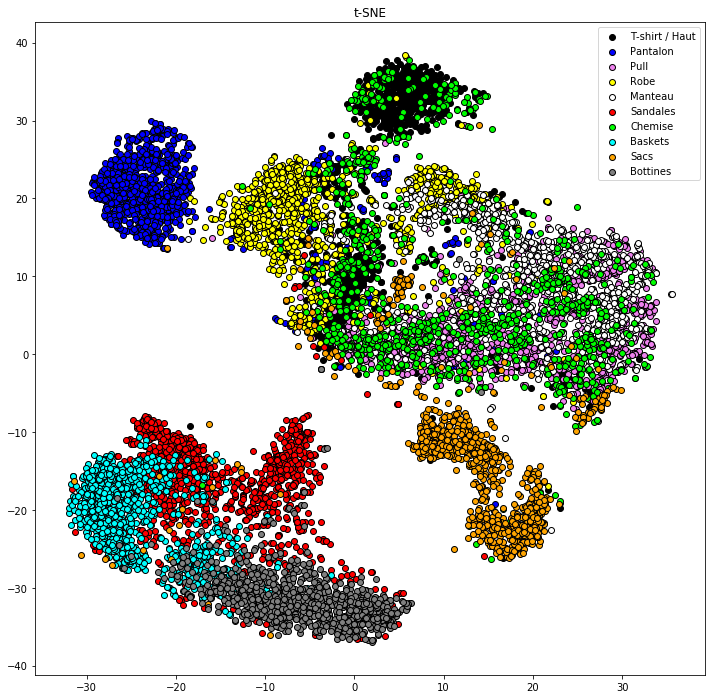

In [40]:
plot_embedding(X_embedded,y_test,"t-SNE")

In [309]:
def convolutional_autoencoder(img_shape=(28, 28, 1)):    
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization(axis=-1)(x)
    shape_before_flattening = K.int_shape(x)
    # 256 dimension
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = UpSampling2D((2, 2),interpolation="bilinear")(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization(axis=-1)(x)
    x = UpSampling2D((2, 2),interpolation="bilinear")(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = UpSampling2D((2, 2),interpolation="bilinear")(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [310]:
autoencoder, encoder = convolutional_autoencoder()

In [311]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_75 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
batch_normalization_76 (Batc (None, 7, 7, 16)          64        
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 4, 4, 16)          2320      
_________________________________________________________________
batch_normalization_77 (Batc (None, 4, 4, 16)          64        
__________

In [312]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [313]:
# Paramètres utilisées sur GPU.
my_epochs = 100
batch_size = 2048

In [314]:
history = autoencoder.fit(X_train_reshape, X_train_reshape,
                epochs=my_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test_reshape, X_test_reshape))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.5634 - val_loss: 0.7734
Epoch 2/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.4279 - val_loss: 0.6528
Epoch 3/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3646 - val_loss: 0.5448
Epoch 4/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3383 - val_loss: 0.4750
Epoch 5/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3277 - val_loss: 0.4253
Epoch 6/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3216 - val_loss: 0.4043
Epoch 7/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3175 - val_loss: 0.3892
Epoch 8/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3144 - val_loss: 0.3527
Epoch 9/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.3119 - val_loss: 0.

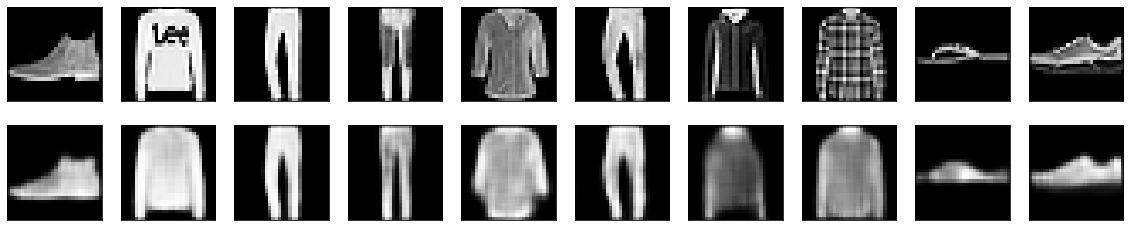

In [315]:
decoded_imgs = autoencoder.predict(X_test_reshape)
display_reconstructed(X_test_reshape, decoded_imgs, 10)

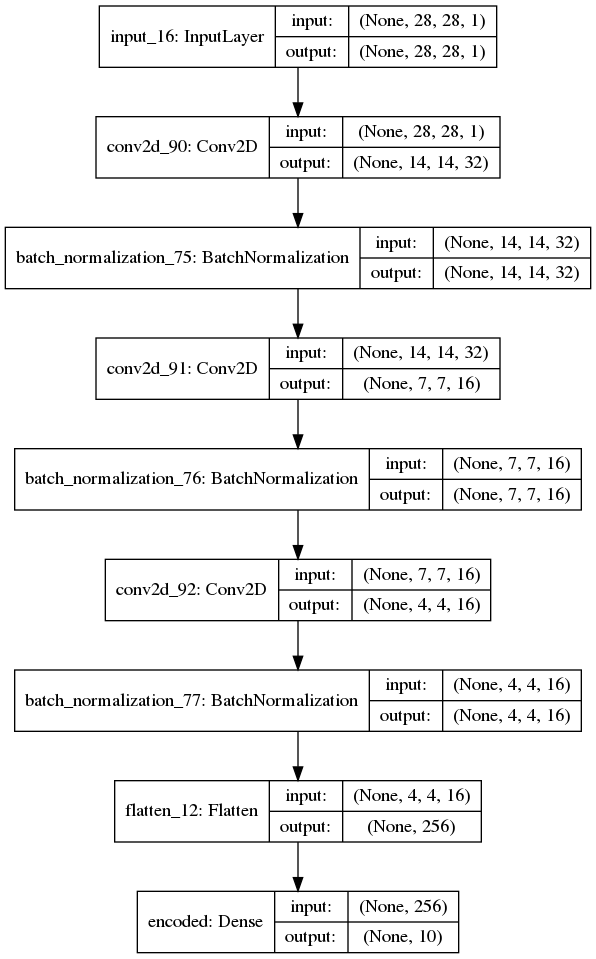

In [316]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

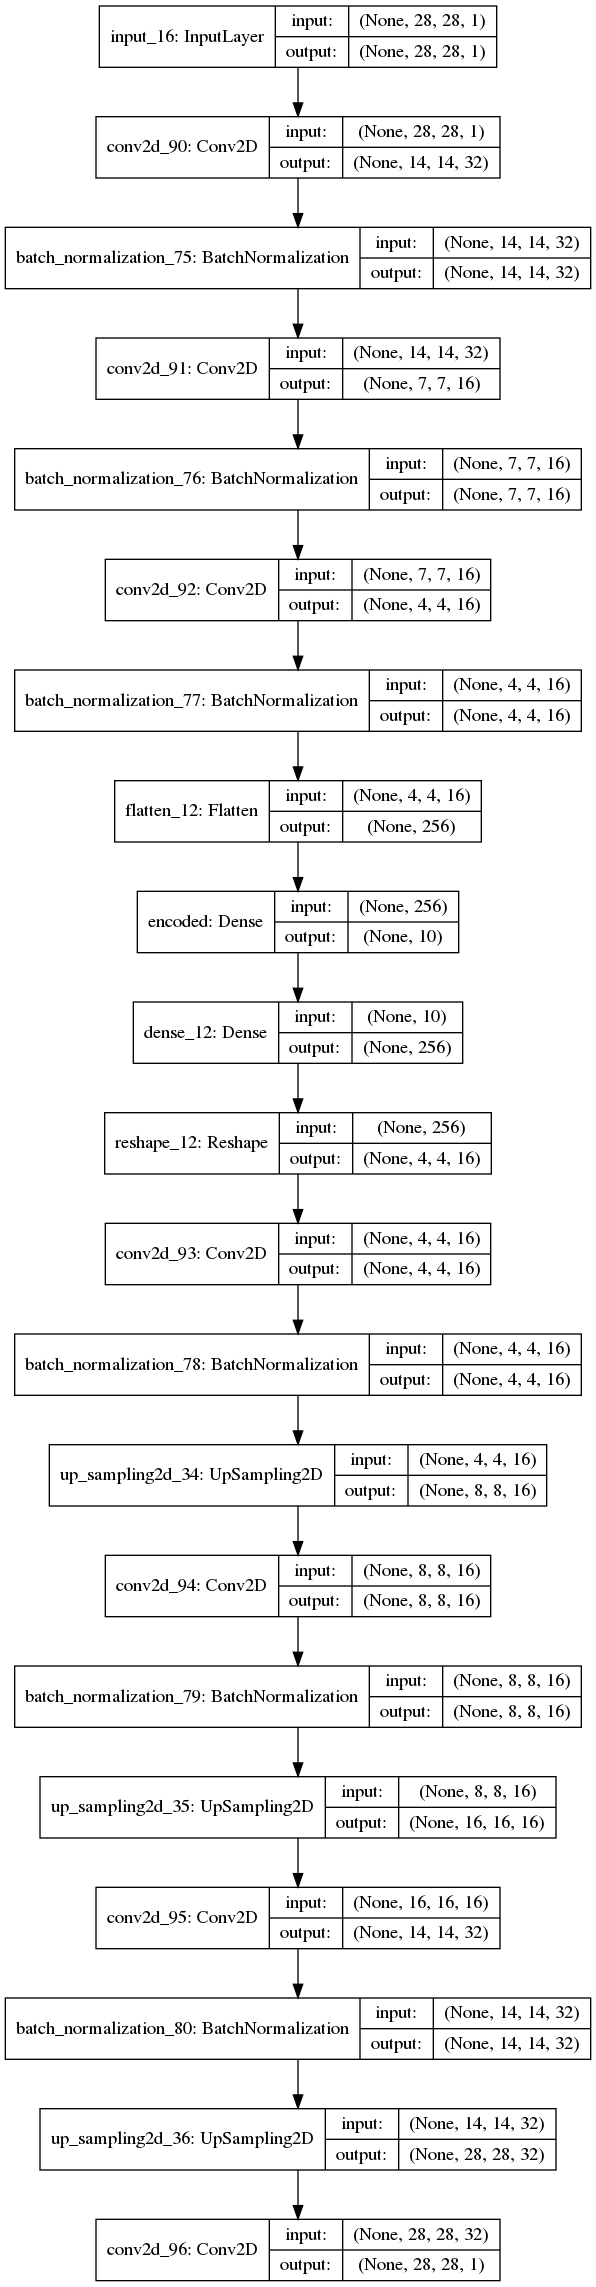

In [317]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png')

In [318]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


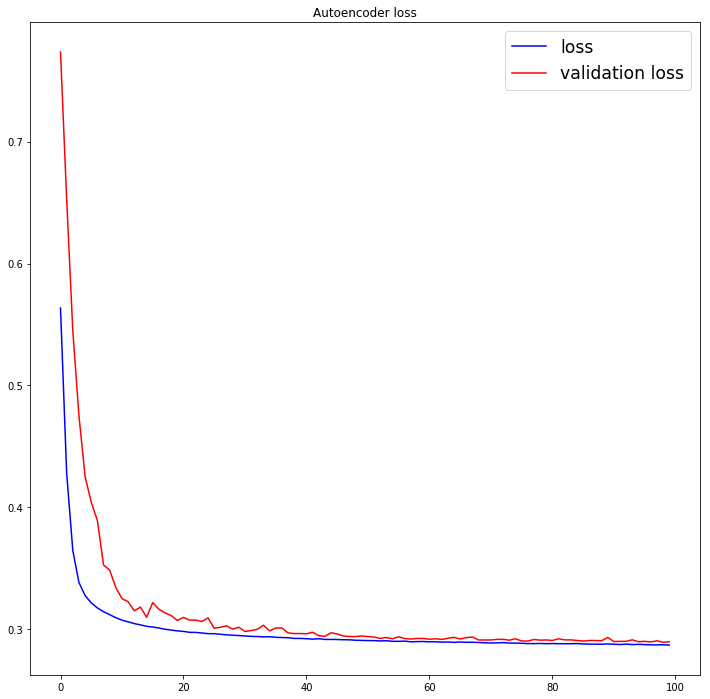

In [342]:
plt.figure(figsize=(12,12))
plt.plot(range(my_epochs), history.history['loss'],'b' ,label='loss')
plt.plot(range(my_epochs),history.history['val_loss'], 'r', label='validation loss')
plt.title('Autoencoder loss')
plt.legend(loc=0, fontsize = 'xx-large')
plt.show()

In [320]:
m = []
for i in range(len(X_test_2d)):
    m.append(compare_psnr(X_test_2d[i].reshape(28, 28),decoded_imgs[i].reshape(28, 28)))

In [321]:
n = []
for i in range(len(X_test_2d)):
    n.append(compare_mse(X_test_2d[i].reshape(28, 28),decoded_imgs[i].reshape(28, 28)))

PSNR de 18 en moyenne et le MSE de 0.015

In [322]:
scipy.stats.describe(m)

DescribeResult(nobs=10000, minmax=(10.170178721810322, 25.841811029481583), mean=18.688801769577516, variance=5.623028834655351, skewness=-0.16704698618472136, kurtosis=-0.11635765324638259)

In [323]:
scipy.stats.describe(n)

DescribeResult(nobs=10000, minmax=(0.002605066997636004, 0.09615727067201513), mean=0.01576149969752732, variance=9.255051077472383e-05, skewness=2.036249436851508, kurtosis=6.829723792700619)

##### K-means sur les images non encodées

In [324]:
kmeans = KMeans(n_clusters=10,n_jobs=mp.cpu_count(),algorithm="elkan",max_iter=100000,precompute_distances=True,n_init=200)

In [325]:
y_pred_init = kmeans.fit_predict(X_test_2d)

In [326]:
acc(y_test, y_pred_init)

0.4864

In [327]:
nmi(y_test,y_pred_init,average_method='arithmetic')

0.5159893970159369

In [328]:
ari(y_test,y_pred_init)

0.35150324216813195

##### K-means sur les images encodées

In [329]:
encoder.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"])

In [330]:
y_train_hot = to_categorical(y_train, 10)
y_test_hot = to_categorical(y_test, 10)

In [331]:
encoder.evaluate(X_test_reshape,y_test_hot)

10000/10000 [==============================] - 3s 271us/step


[2.461467560577393, 0.0795]

In [332]:
y_pred_encoded = kmeans.fit_predict(encoder.predict(X_test_reshape))

In [333]:
acc(y_test, y_pred_encoded)

0.5635

In [334]:
nmi(y_test,y_pred_encoded,average_method="arithmetic")

0.5979057814480735

In [335]:
ari(y_test,y_pred_encoded)

0.43606620131975005

##### t-SNE sur les images encodées

In [336]:
X_embedded = model.fit_transform(encoder.predict(X_test_reshape))

In [337]:
print("KL Divergence:",round(float(model.kl_divergence_),4))

KL Divergence: 0.8863


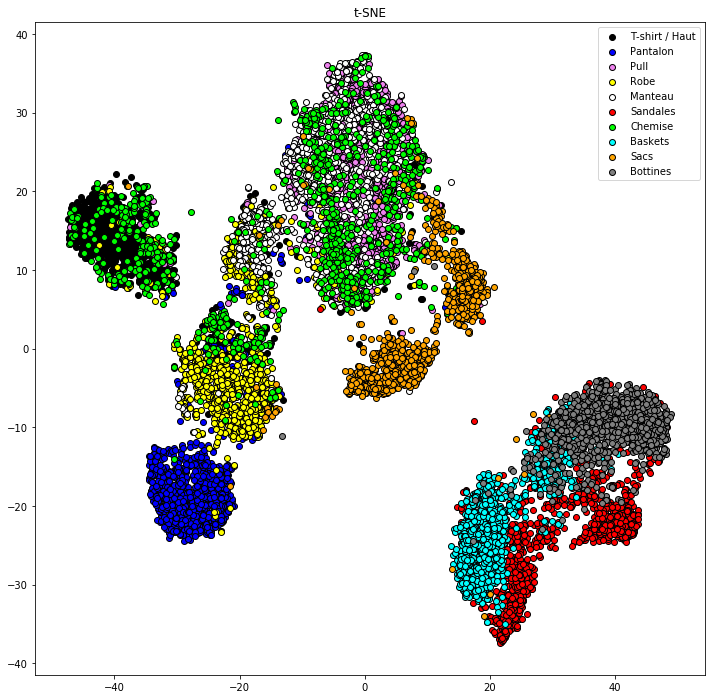

In [338]:
plot_embedding(X_embedded,y_test,"t-SNE")